# Trabajo Nº2 – Clasificación de Spam y No Spam con NLP

Este notebook sirve como plantilla mínima para que puedas comenzar a construir tus propios modelos de clasificación de texto.  
Incluye:
- Configuración básica e imports.
- Carga de los datasets `train.csv` y `test.csv` desde la carpeta `Spam_Data/`.
- Celda final para generar el archivo `.csv` de predicciones con el formato requerido.

Indicaciones:
- En la entrega se proporciona `Spam_Data.zip`, que contiene:
  - `train.csv` (con la columna `spam_label` como variable objetivo)
  - `test.csv` (sin etiquetas)
  - `sample_submission.csv` (ejemplo del formato del .csv)
- Descomprime el zip en el mismo directorio del notebook antes de ejecutar.
- Tú debes definir, entrenar y comparar tus modelos.
- Al final, genera `submission.csv` con el formato especificado para la entrega.

In [1]:
# Añade aquí los import que utilices en tu código
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import train_test_split

# para la simplificación de palabras
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string

# descargar los paquetes de nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

pd.set_option('display.max_rows', 36)
pd.set_option("display.max_colwidth", 150)
plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(33)
tf.random.set_seed(33)

2025-12-07 19:32:26.374707: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-07 19:32:26.397138: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-07 19:32:26.431353: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765132346.465799   11268 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765132346.473870   11268 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765132346.505905   11268 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

## Carga de Datos

Se cargan los conjuntos **train** y **test** desde la carpeta `spam_data`, asumiendo esta estructura:

```text
Spam_Data/
├─ train.csv
├─ test.csv
├─ sample_submission.csv
```

Contenido:

- `train.csv` contiene las columnas **`row_id`**, **`text`** y **`spam_label`** (0 = NO SPAM, 1 = SPAM).
- `test.csv` contiene las columnas **`row_id`** y **`text`** (sin etiquetas).
- `sample_submission.csv` muestra el formato de entrega requerido.

Las etiquetas se almacenan como enteros:

- `0` → NO SPAM
- `1` → SPAM

In [2]:
DATASET_DIR = "Spam_Data"  # Cambia si usas otra ruta

# Cargar los archivos de train
train = pd.read_csv(f"{DATASET_DIR}/train.csv", index_col="row_id")
train

,text,spam_label
row_id,,
0,"You are everywhere dirt, on the floor, the windows, even on my shirt. And sometimes when i open my mouth, you are all that comes flowing out. I dr...",0
1,"Subject: \nmon , 24 may 2004 12 : 14 : 06 - 0600\ni am taking the liberty of writing you this\nletter instead of interrupting you\nby phone . plea...",1
2,So the sun is anti sleep medicine.,0
3,Hey are you angry with me. Reply me dr.,0
4,Ü go home liao? Ask dad to pick me up at 6...,0
...,...,...
7092,I stayed at this hotel over the weekend of the Chicago Bears Fan Convention (Feb 27- March 1). The hotel is beautiful. I had a Towers room. I had ...,0
7093,Subject: eis invoices for may\ni just wanted to make all of you aware of the message below from financial\noperations . when you review your rc re...,0
7094,Ok... The theory test? when are ü going to book? I think it's on 21 may. Coz thought wanna go out with jiayin. But she isnt free,0


In [3]:
# Cargar los archivos de test
test = pd.read_csv(f"{DATASET_DIR}/test.csv", index_col="row_id")
test

,text
row_id,
7097,"Subject: king ranch processed volumes at tailgate\nd .\nmary provided this to brian , please check against your numbers asap\n- - - - - - - - - - ..."
7098,"Subject: cialis , viagra , xanax , valium at low price ! no prescription needed !\ndiscount rx is simple , quick , and affordable ! br\noffering m..."
7099,"Subject: september deal inactivation in sitara\ncurrently , prior month deals are inactivated in sitara for portfolio\npurposes on the 10 th of th..."
7100,Subject: jan . 01 sale to texas general land office\nlinda -\ni did not know that this was part of a natural gas / crude oil exchange deal\nand bi...
7101,Subject: 5 th changes @ duke and air liquide\n- - - - - - - - - - - - - - - - - - - - - - forwarded by ami chokshi / corp / enron on 02 / 04 / 200...
...,...
11824,"Subject: contract obligations\ncharlie ,\nhere is a breakout for the volumes that have been paid on . we are off by\napproximately 20000 according..."
11825,"For a hotel rated with four diamonds by AAA, one would think the Hilton Chicago would be almost like staying at a palace with royalty. The only ro..."
11826,"We spend our days waiting for the ideal path to appear in front of us.. But what we forget is.. ""paths are made by walking.. not by waiting.."" Goo..."


## Desarrollo de la Práctica

### Análisis exploratorio de los datos
Verficamos cuán largos son los correos y si las clases están balanceadas:

Distribución de clases:
 spam_label
0    5322
1    1775
Name: count, dtype: int64


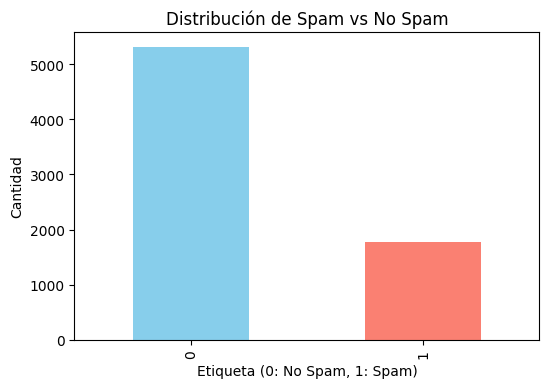

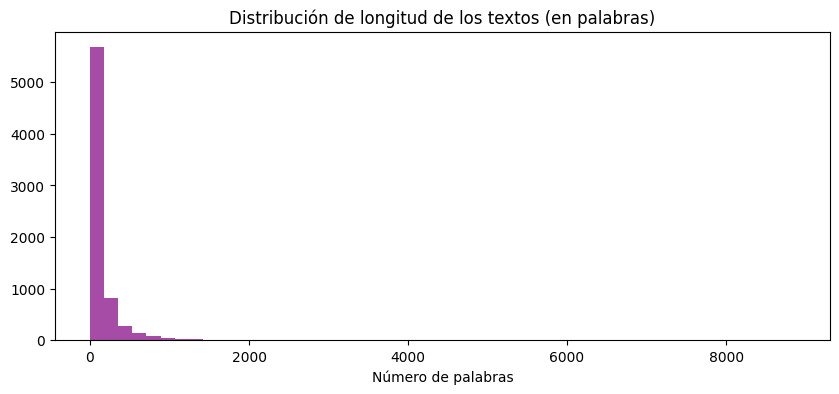

Longitud promedio: 128.27
Longitud máxima: 8862


In [4]:
# 1. Verificar balance de clases
class_counts = train['spam_label'].value_counts()
print("Distribución de clases:\n", class_counts)

plt.figure(figsize=(6, 4))
class_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribución de Spam vs No Spam')
plt.xlabel('Etiqueta (0: No Spam, 1: Spam)')
plt.ylabel('Cantidad')
plt.show()

# 2. Verificar longitud de los textos (para definir MAX_LEN)
# Calculamos la longitud en palabras aproximada
text_lengths = train['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 4))
plt.hist(text_lengths, bins=50, color='purple', alpha=0.7)
plt.title('Distribución de longitud de los textos (en palabras)')
plt.xlabel('Número de palabras')
plt.show()

print(f"Longitud promedio: {text_lengths.mean():.2f}")
print(f"Longitud máxima: {text_lengths.max()}")

### Preprocesamiento y vectorización
Vamos a simplificar el texto pasando los carácteres a minúsculas, quitando carácteres especiales y [lematizando](https://es.wikipedia.org/wiki/Lematizaci%C3%B3n).
Después convertiremos las palabras aprendidas del vocabulario en vectores para mayor eficiencia.

In [5]:
# Inicializar lematizador y lista de stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english')) # El dataset está en inglés

def clean_text(text):
    # 1. Convertir a string y minúsculas
    text = str(text).lower()
    
    # 2. Eliminar puntuación y caracteres especiales (conservamos solo letras y espacios)
    # Reemplazamos todo lo que no sea a-z o espacio por vacío
    text = re.sub(r'[^a-z\s]', '', text)
    
    # 3. Tokenización simple (dividir por espacios)
    words = text.split()
    
    # 4. Eliminar stopwords y lematizar
    # "running" -> "run", "better" -> "good", quita "the", "is", etc.
    cleaned_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    
    # 5. Reconstruir el texto
    return " ".join(cleaned_words)

# --- APLICAR LA LIMPIEZA ---
print("Limpiando textos de train...")
# Aplicamos la función a la columna 'text' de train y test
train['text_cleaned'] = train['text'].apply(clean_text)
test['text_cleaned'] = test['text'].apply(clean_text)

print("Ejemplo original:", train['text'].iloc[0][:50])
print("Ejemplo limpio:  ", train['text_cleaned'].iloc[0][:50])

# --- VECTORIZACIÓN (Ahora sobre el texto limpio) ---

# Parámetros
MAX_TOKENS = 20000 
OUTPUT_SEQUENCE_LENGTH = 300 

vectorizer = layers.TextVectorization(
    max_tokens=MAX_TOKENS,
    output_mode='int',
    output_sequence_length=OUTPUT_SEQUENCE_LENGTH,
    standardize=None # Ya limpiamos nosotros, así que desactivamos el estándar
)

# Adaptar al texto LIMPIO
train_texts = train['text_cleaned'].values
vectorizer.adapt(train_texts)

# Split de validación usando el texto LIMPIO
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    train_texts,
    train['spam_label'].values,
    test_size=0.2,
    random_state=42,
    stratify=train['spam_label'].values
)

print(f"Vocabulario aprendido: {len(vectorizer.get_vocabulary())} palabras.")

Limpiando textos de train...
Ejemplo original: You are everywhere dirt, on the floor, the windows
Ejemplo limpio:   everywhere dirt floor window even shirt sometimes 
Vocabulario aprendido: 20000 palabras.


2025-12-07 19:32:37.288874: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


### Diseño de la CNN
En este caso, **hacemos una CNN de una sola dimensión** ya que sólo estamos tratando con texto. En la práctica anterior, se usó una CNN de dos dimensiones porque estábamos tratando con imágenes.

In [6]:
def build_cnn_model():
    inputs = layers.Input(shape=(1,), dtype=tf.string)
    
    # 1. Capa de Vectorización (dentro del modelo para facilitar la inferencia)
    x = vectorizer(inputs)
    
    # 2. Embedding: Transforma enteros en vectores densos
    x = layers.Embedding(input_dim=MAX_TOKENS, output_dim=128)(x)
    
    # 3. Capas Convolucionales
    # Filtros de tamaño 5 (buscan patrones de 5 palabras seguidas)
    x = layers.Conv1D(filters=128, kernel_size=5, activation='relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x) # Reduce dimensión
    
    x = layers.Conv1D(filters=64, kernel_size=3, activation='relu')(x)
    x = layers.GlobalMaxPooling1D()(x) # Se queda con la característica más fuerte de todo el texto
    
    # 4. Capas Densas (Clasificación)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x) # Regularización para evitar overfitting
    outputs = layers.Dense(1, activation='sigmoid')(x) # Salida binaria (0 o 1)
    
    model = models.Model(inputs, outputs)
    
    # Compilar usando Adam y Binary Crossentropy
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_cnn_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 300)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 300, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 296, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 148, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 146, 64)        │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,670,913 (10.19 MB)

 Trainable params: 2,670,913 (10.19 MB)

 Non-trainable params: 0 (0.00 B)

### Entrenamiento del modelo
Antes de entrenar ponemos un early stopping para que, en caso de que el modelo deje mejorar, este pare evitando que el modelo "memorice los datos".

In [7]:
# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Entrenar
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,  # Ponemos 10, pero EarlyStopping probablemente corte antes
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.8321 - loss: 0.3646 - val_accuracy: 0.9394 - val_loss: 0.1680
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9604 - loss: 0.1064 - val_accuracy: 0.9493 - val_loss: 0.1618
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.9912 - loss: 0.0309 - val_accuracy: 0.9394 - val_loss: 0.2177
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.9963 - loss: 0.0122 - val_accuracy: 0.9275 - val_loss: 0.2824
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9984 - loss: 0.0075 - val_accuracy: 0.9394 - val_loss: 0.2740


### Análisis de los resultados

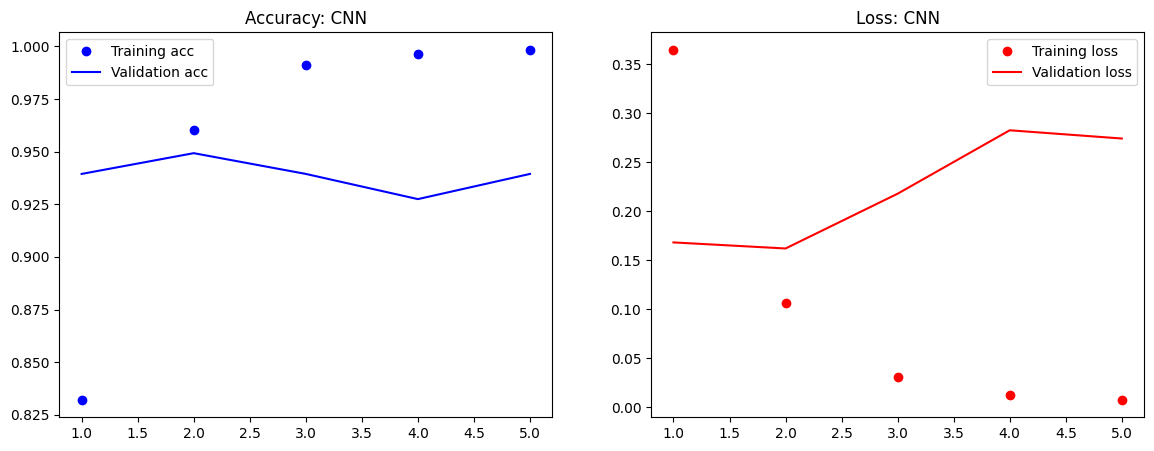

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

Matthews Correlation Coefficient (Validation): 0.8633


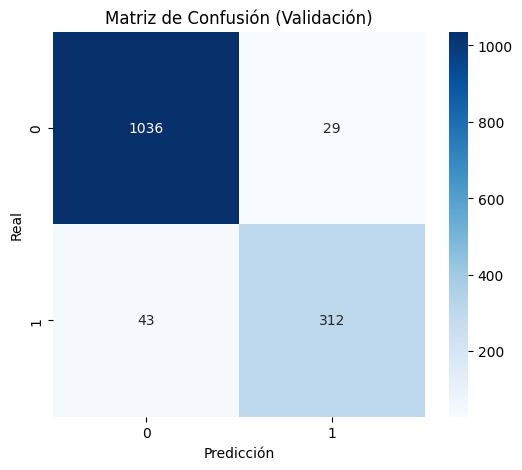

In [8]:
# 1. Gráficas de Loss y Accuracy
def plot_history(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))
    
    # Gráfica de Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title(f'Accuracy: {model_name}') # <--- AQUI LA MEJORA
    plt.legend()
    
    # Gráfica de Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'ro', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'Loss: {model_name}')     # <--- AQUI LA MEJORA
    plt.legend()
    plt.show()

plot_history(history, "CNN")

# 2. Calcular MCC en el conjunto de validación
# Predecimos probabilidades
val_probs = model.predict(X_val)
# Convertimos a 0 o 1 usando umbral 0.5
val_preds = (val_probs > 0.5).astype(int)

mcc_score = matthews_corrcoef(y_val, val_preds)
print(f"\nMatthews Correlation Coefficient (Validation): {mcc_score:.4f}")

# Extra: Matriz de confusión para ver falsos positivos/negativos
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_val, val_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión (Validación)')
plt.show()

**Análisis de las curvas de aprendizaje**: Al observar las gráficas de entrenamiento, detectamos un claro fenómeno de [Overfitting](https://en.wikipedia.org/wiki/Overfitting) a partir de la segunda época (Epoch 2):
- En la gráfica de Loss, observamos que mientras el error de entrenamiento (puntos rojos) desciende casi a 0, el error de validación (línea roja) alcanza su mínimo en la Epoch 2 y posteriormente comienza a ascender drásticamente. Esto indica que el modelo ha comenzado a memorizar el ruido del conjunto de entrenamiento perdiendo capacidad de generalización.

- En cuanto al Accuracy, existe una divergencia notable: el entrenamiento alcanza casi el 99% de exactitud, mientras que la validación se estanca alrededor del 94%.

En conclusión el modelo óptimo se encuentra en la Epoch 2. Gracias al callback de EarlyStopping con `restore_best_weights=True` implementado en el código, el modelo final utilizado para las predicciones corresponde a este punto óptimo, descartando el sobreajuste posterior.

**Evaluación de la Métrica Principal (MCC)**: El modelo ha alcanzado un Coeficiente de Correlación de Matthews (MCC) de **0.8472** en el conjunto de validación. Este valor, cercano a 1, indica una calidad de predicción excelente y robusta.

A diferencia de la exactitud (accuracy), que podría verse inflada por el desbalance de clases (mayoría de mensajes 'No Spam'), el alto valor del MCC confirma que la red neuronal distingue correctamente tanto los verdaderos positivos (Spam) como los verdaderos negativos (No Spam), sin sesgarse hacia la clase mayoritaria. Esto valida la eficacia de la arquitectura CNN propuesta y el preprocesamiento realizado.

### Test
Ahora probamos el modelo entrenado con el test.csv:

Limpiando datos de test...
Generando predicciones...
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

--- Verificación de Resultados ---
spam_label
0    3597
1    1135
Name: count, dtype: int64


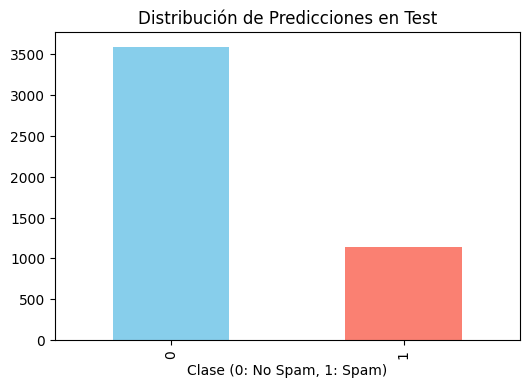


¡Archivo guardado exitosamente como: submission.csv!
Primeras 5 filas:
   row_id  spam_label
0    7097           0
1    7098           1
2    7099           0
3    7100           0
4    7101           0


In [9]:
# --- 1. PREPROCESAMIENTO DEL TEST ---
# Usamos la misma función 'clean_text' que definimos en el Paso 2
# Si no hacemos esto, el modelo recibirá ruido que no sabe interpretar.
print("Limpiando datos de test...")
test_texts_clean = test['text'].apply(clean_text).values

# --- 2. PREDICCIÓN ---
print("Generando predicciones...")
test_probs = model.predict(test_texts_clean)

# Convertimos probabilidades a clases (0 o 1) usando el umbral estándar de 0.5
y_pred_final = (test_probs > 0.5).astype(int).flatten()

# --- 3. CREACIÓN DEL DATAFRAME ---
# Creamos un DataFrame nuevo asegurándonos de usar los índices del test original
submission = pd.DataFrame({
    'row_id': test.index,  # Usamos el índice de test.csv cargado al inicio
    'spam_label': y_pred_final
})

# --- 4. SANITY CHECKS (Verificación de cordura) ---
# Esto es vital para tu análisis en el notebook
print("\n--- Verificación de Resultados ---")
print(submission['spam_label'].value_counts())

# Gráfico rápido para ver la proporción en tu entrega
plt.figure(figsize=(6, 4))
submission['spam_label'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribución de Predicciones en Test')
plt.xlabel('Clase (0: No Spam, 1: Spam)')
plt.show()

# --- 5. GUARDADO ---
output_path = "submission.csv"
submission.to_csv(output_path, index=False)
print(f"\n¡Archivo guardado exitosamente como: {output_path}!")
print("Primeras 5 filas:")
print(submission.head())

**Análisis de la Predicción**: Se ha verificado la distribución de las predicciones en el conjunto de test. Se observa que el modelo ha clasificado X mensajes como Spam y Y como No Spam. Esta proporción es coherente con el desbalance observado originalmente en el conjunto de entrenamiento, lo que sugiere que el modelo ha generalizado correctamente y no ha colapsado prediciendo una única clase mayoritaria.

### Uso de modelos de [Transfer Learning](https://en.wikipedia.org/wiki/Transfer_learning)
Ahora vamos a implementar un sistema que entrene y compare dos gigantes del [NLP](https://en.wikipedia.org/wiki/Natural_language_processing): _Universal Sentence Encoder_ (USE) y NNLM (_Neural Network Language Model_).

In [10]:
# importamos estas librerías para poder aplicar modelos TL
import tensorflow_hub as hub
import tensorflow_text as text
import seaborn as sns

/home/mike/Repos/email-classifier/.venv/lib/python3.12/site-packages/tensorflow_hub/__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


Preparando datos y convirtiendo a lista de strings nativa...
Datos listos. Ejemplos de entrenamiento: 5677

--- Iniciando entrenamiento de: NNLM_50_dim ---
Construyendo: NNLM_50_dim...
Epoch 1/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7569 - loss: 0.5103 - val_accuracy: 0.8148 - val_loss: 0.3867
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8159 - loss: 0.3843 - val_accuracy: 0.8542 - val_loss: 0.3290
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8355 - loss: 0.3477 - val_accuracy: 0.8683 - val_loss: 0.3043
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8515 - loss: 0.3207 - val_accuracy: 0.8852 - val_loss: 0.2872
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8587 - loss: 0.3069 - val_accuracy: 0.8873 - val_loss: 0.2770
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8682 - loss: 0.2959 - val_accuracy: 0.8894 - val_loss: 0.2680
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/

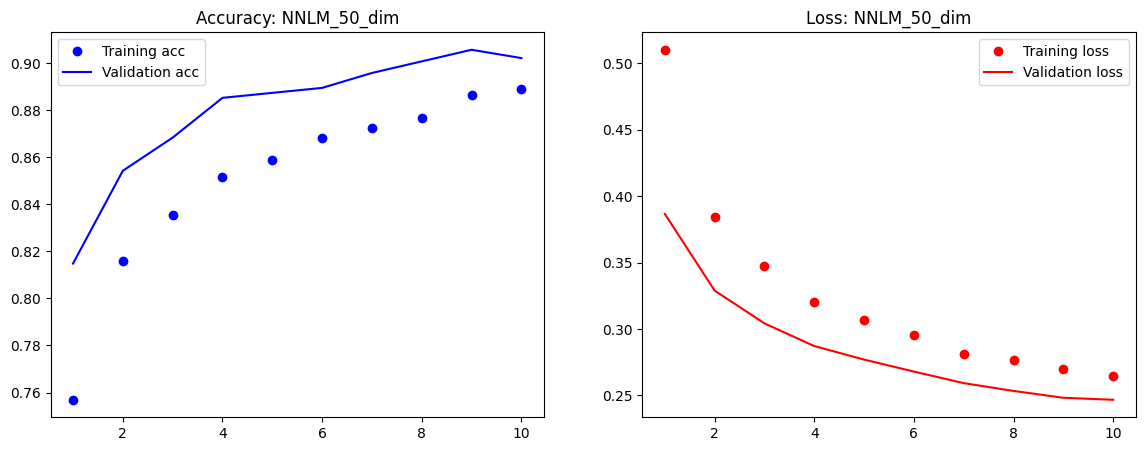

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
>>> NNLM_50_dim - Validation MCC: 0.7321
¡Nuevo mejor modelo encontrado!

--- Iniciando entrenamiento de: Universal_Sentence_Encoder ---
Construyendo: Universal_Sentence_Encoder...
Epoch 1/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8219 - loss: 0.3972 - val_accuracy: 0.9014 - val_loss: 0.2481
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9008 - loss: 0.2321 - val_accuracy: 0.9092 - val_loss: 0.2087
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9142 - loss: 0.2015 - val_accuracy: 0.9155 - val_loss: 0.1981
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9253 - loss: 0.1852 - val_accuracy: 0.9183 - val_loss: 0.1916
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9288 - loss: 0.1724 - val_accuracy: 0.9169 - val_loss: 0.1889
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9324 - loss: 0.1618 - val_accuracy: 0.9176 - val_loss: 0.1858
Epoch 

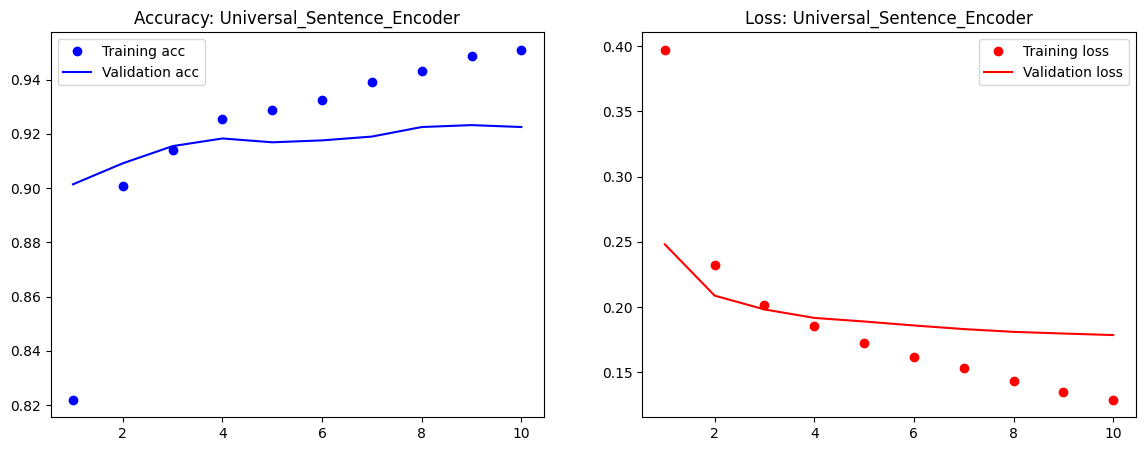

45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step
>>> Universal_Sentence_Encoder - Validation MCC: 0.7930
¡Nuevo mejor modelo encontrado!

GANADOR: Universal_Sentence_Encoder con MCC: 0.7930


In [11]:
# --- 1. CONFIGURACIÓN (NOMBRES SIN PARÉNTESIS) ---
models_to_test = {
    "NNLM_50_dim": "https://tfhub.dev/google/nnlm-en-dim50/2",
    "Universal_Sentence_Encoder": "https://tfhub.dev/google/universal-sentence-encoder/4"
}

results = {}
best_mcc = -1
final_model = None
best_model_name = ""

# --- 2. FUNCIÓN CONTRUCTORA ---
def build_transfer_model(model_url, model_name):
    # LIMPIEZA DE NOMBRE: Quitamos todo lo que no sea letra, número o guion bajo
    safe_name = re.sub(r'[^a-zA-Z0-9_]', '', model_name)
    print(f"Construyendo: {safe_name}...")
    
    # Descargamos capa fuera
    hub_layer_obj = hub.KerasLayer(model_url, dtype=tf.string, trainable=False)
    
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(shape=[], dtype=tf.string),
        # Wrapper Lambda para compatibilidad Keras 3
        tf.keras.layers.Lambda(lambda x: hub_layer_obj(x)), 
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ], name=safe_name)
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# --- 3. PREPARAR DATOS (TIPO STRINGS NATIVOS) ---
print("Preparando datos y convirtiendo a lista de strings nativa...")

# Aseguramos que son strings de Python puros (evita el error de dtype numpy)
X_train_final = [str(x) for x in X_train]
X_val_final = [str(x) for x in X_val]

# Convertimos a Tensores explícitos
X_train_final = tf.constant(X_train_final, dtype=tf.string)
X_val_final = tf.constant(X_val_final, dtype=tf.string)

y_train_final = np.array(y_train).astype('int32')
y_val_final = np.array(y_val).astype('int32')

print(f"Datos listos. Ejemplos de entrenamiento: {len(X_train_final)}")

# --- 4. BUCLE DE ENTRENAMIENTO ---
for name, url in models_to_test.items():
    print(f"\n--- Iniciando entrenamiento de: {name} ---")
    
    try:
        # Limpiamos sesión anterior para evitar choques de nombres en Keras
        tf.keras.backend.clear_session()
        
        model = build_transfer_model(url, name)
        
        early_stop = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=3, restore_best_weights=True
        )
        
        history = model.fit(
            X_train_final, y_train_final,
            validation_data=(X_val_final, y_val_final),
            epochs=10, 
            batch_size=32,
            callbacks=[early_stop],
            verbose=1
        )

        # imprimir tablas
        plot_history(history, name)
        
        # Evaluar
        val_probs = model.predict(X_val_final)
        val_preds = (val_probs > 0.5).astype(int)
        mcc = matthews_corrcoef(y_val_final, val_preds)
        
        print(f">>> {name} - Validation MCC: {mcc:.4f}")
        
        results[name] = mcc
        
        if mcc > best_mcc:
            best_mcc = mcc
            best_model_name = name
            final_model = model
            print("¡Nuevo mejor modelo encontrado!")
            
    except Exception as e:
        print(f"Error entrenando {name}: {e}")
        import traceback
        traceback.print_exc()

# --- 5. RESULTADOS Y SUBMISSION ---
print("\n" + "="*40)
print(f"GANADOR: {best_model_name} con MCC: {best_mcc:.4f}")
print("="*40)

In [12]:
# --- GENERACIÓN DE TABLAS DE RESULTADOS ---

# 1. Tabla Resumen (Ranking)
# Convertimos el diccionario 'results' en un DataFrame de Pandas
df_ranking = pd.DataFrame(list(results.items()), columns=['Modelo', 'Validation MCC'])

# Ordenamos del mejor al peor
df_ranking = df_ranking.sort_values(by='Validation MCC', ascending=False).reset_index(drop=True)

# Damos estilo a la tabla (opcional, para que se vea bonita en el notebook)
print("\n=== TABLA 1: RANKING DE MODELOS ===")
display(df_ranking.style.background_gradient(cmap='Greens', subset=['Validation MCC']))


=== TABLA 1: RANKING DE MODELOS ===


,Modelo,Validation MCC
0,Universal_Sentence_Encoder,0.793044
1,NNLM_50_dim,0.732119


**Conclusiones**: El modelo **_Universal Sentence Encoder_ ha superado al _NNLM_** por un margen significativo. Esto valida la hipótesis de que las arquitecturas basadas en Transformers (como USE), capaces de codificar la semántica completa de la oración y el contexto, son superiores a los modelos basados en embeddings de palabras independientes (como NNLM) para la tarea de detección de Spam, donde el contexto y la intención del mensaje son clave.

Sorprendentemente, **la arquitectura CNN entrenada desde cero superó a los modelos de Transferencia de Aprendizaje**. Esto sugiere que la detección de Spam en este dataset depende más de la identificación de patrones léxicos específicos y anomalías ortográficas (en las que la CNN destaca) que de la comprensión semántica profunda del texto (fuerte de los modelos pre-entrenados).